### Fine-Tuning Quantised GPT-2 (4bit) using Lora

Imports

In [1]:
from datasets import load_dataset, ClassLabel
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          Trainer,
                          TrainingArguments,
                          BitsAndBytesConfig
)
from peft import (LoraConfig,
                  TaskType,
                  PeftModel,
                  get_peft_model,
                  prepare_model_for_kbit_training
                  )
from sklearn.metrics import (
	accuracy_score,
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

#model name id in hugging face
mdl_tok_name = "gpt2"

Test Nvidia CUDA in torch

In [2]:
# Importing required function
import torch

# Check if CUDA is available
if torch.cuda.is_available():
	print(torch.cuda.is_available())
	print(torch.cuda.device_count())
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA is not available on this system. Please ensure that a CUDA-capable device is properly configured.")


True
1
NVIDIA GeForce RTX 4070 Ti


#### Defining Evaluation Metrics as a function

In [3]:
def compute_metrics(eval_pred):
	# Unpack predictions and labels
	predictions, labels = eval_pred
	# Get the predicted class (argmax selects the class with the highest score)
	predictions = np.argmax(predictions, axis = 1)
	# Compute metrics
	accuracy = accuracy_score(y_true = labels, y_pred = predictions)
	precision = precision_score(y_true =labels, y_pred =predictions)
	recall = recall_score(y_true = labels, y_pred = predictions)
	f1 = f1_score(y_true = labels, y_pred = predictions)
	# Return all metrics
	return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#### Creating a confusion matrix visualisation function

In [4]:
def create_confusion_matrix(data, cl_classes, trainer_ ,title_text = 'Confusion Matrix - Validation Set'):

 results = trainer_.predict(data)
 # Create confusion matrix
 y_true = results.label_ids
 y_pred = results.predictions.argmax(axis=1)
 cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
 # Display the confusion matrix
 disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cl_classes)
 disp.plot(cmap=plt.cm.Blues)
 plt.title(title_text, pad= 12)
 plt.show()
 return None

#### Loading the filtered dataset

In [5]:
# Define the file path to the dataset
file_path = Path("data/filtered_dataset.csv")

# Load the dataset using Hugging Face's `load_dataset`
dataset = load_dataset('csv', data_files = str(file_path))

# Inspect the unique values in the 'labels' column
product_classes = dataset["train"].unique("Product")

# Convert the 'Product' column to a ClassLabel feature
product_label = ClassLabel(names=product_classes)
dataset = dataset.cast_column("Product", product_label)

# Rename the columns: "Product" to "labels", and "Consumer complaint narrative" to "complaint"
dataset = dataset.rename_column("Product", "labels")
dataset = dataset.rename_column("Consumer complaint narrative", "complaint")

# Extract the features (columns) we want
dataset = \
    dataset["train"].select_columns(
        ["complaint", "labels"]
    ).train_test_split(
        test_size=0.2,
        shuffle=True,
        seed=23,
        stratify_by_column="labels"
    )
splits = ["train", "test"]

# View the resulting dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['complaint', 'labels'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['complaint', 'labels'],
        num_rows: 400
    })
})


#### Inspecting the labels

Credit card or Prepaid Card is labeled as 0 and  Mortgage is labeled as 1

In [6]:
product_label

ClassLabel(names=['Mortgage', 'Credit card or prepaid card'], id=None)

#### Preprocess dataset

Tokenizing 'Consumer complaint narrative' feature values

In [7]:
tokenizer = AutoTokenizer.from_pretrained(mdl_tok_name)
tokenizer.pad_token = tokenizer.eos_token

# Let's use a lambda function to tokenize all the examples
tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["complaint"],
                            truncation=True,
                            padding=True,
                            return_tensors = "pt"
                            ),
	    batched=True,

    )

# Inspect the available columns in the dataset
tokenized_dataset["train"]

Dataset({
    features: ['complaint', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})

#### Quantisation configuration

In [8]:
# Define 4-bit configuration
bnb_config = BitsAndBytesConfig(
	load_in_4bit = True,  # Enabling 4-bit quantization
	bnb_4bit_use_double_quant = True,  # Using double quantization for better accuracy
	bnb_4bit_quant_type = "nf4",  # Using NormalFloat4 for higher precision (than fp4)
	bnb_4bit_compute_dtype = torch.bfloat16
)


#### Loading Model with quantisation configuration

In [9]:
model_4b = AutoModelForSequenceClassification.from_pretrained(
    mdl_tok_name,
    num_labels = 2,
    id2label = {0: "Mortgage", 1: "Credit card or prepaid card"},
    label2id = {"Credit card or prepaid card": 0, "Mortgage": 1},
	device_map = "auto", # Automatically move to GPU
	quantization_config = bnb_config,  # Passing the bitsandbytes config
	torch_dtype="auto"
)

# Update the model config with the pad token ID
model_4b.config.pad_token_id = tokenizer.pad_token_id


print(model_4b)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, ele

In [10]:
model_4b.gradient_checkpointing_enable()
model_4b = prepare_model_for_kbit_training(model_4b)

#### Lora Configuration for gpt-2 model


In [11]:
lora_config = \
	LoraConfig(
		r = 6,  # Low-rank dimension
		target_modules = ["c_attn", "c_proj", "c_fc"],
		task_type = TaskType.SEQ_CLS,  # Task type: Sequence Classification
		lora_alpha = 32,  # Scaling factor: 32, should consider to increase for larger models
		lora_dropout = 0.1,  # Dropout, increase slightly if facing overfitting,
		bias = "none"
	)

#### Loading foundation model as PEFT model

In [12]:
peft_model = get_peft_model(model_4b, lora_config)
peft_model.print_trainable_parameters()

trainable params: 886,272 || all params: 125,327,616 || trainable%: 0.7072


#### Define Trainer to fine-tune the foundation model

The HuggingFace Trainer class handles the training and eval loop for PyTorch.

You can find more at this [link](https://huggingface.co/docs/transformers/main_classes/trainer).

In [13]:
trainer = Trainer(
    model= peft_model,
    args=TrainingArguments(
        output_dir= "./data/creditc_mortg",
        # Learning rate
        learning_rate= 2e-5,  #2e-5
        # Train/Validate batch size
        per_device_train_batch_size= 8,  #8 # Batch size to avoid memory crashes
        per_device_eval_batch_size= 8, #8 # Same for evaluation
        # Evaluate and save the model after each epoch
        eval_strategy= "epoch", # Evaluate at the end of each epoch
        save_strategy= "epoch", # Save model checkpoint every epoch
	    # Epochs and weight decay
        num_train_epochs= 10,
        weight_decay= 0.01,  #Standard weight decay
	    # Resource management
		gradient_accumulation_steps= 4,  # Simulate larger batches with accumulation
	    #
        load_best_model_at_end= True,
	    use_cpu= False, # Ensure no GPU usage
	    seed = 42,
	    data_seed = 42,

	    # Enable logging for losses
	    logging_dir= ".data/logs/gpt2_q4_lora_logs", #dir to save logs
        logging_strategy = "epoch", #log at regular intervals
	    log_level = 'error'
    ),
    train_dataset= tokenized_dataset["train"],
    eval_dataset= tokenized_dataset["test"],
    tokenizer= tokenizer,
    data_collator= DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics= compute_metrics,
)

C:\Users\vtsoumpris\AppData\Local\Temp\ipykernel_4632\2934826972.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Start fine-tuning

In [ ]:
trainer.train()

#### Final fine-tuned model evaluation metrics

In [15]:
trainer.evaluate()

{'eval_loss': 0.30812838673591614,
 'eval_accuracy': 0.8725,
 'eval_precision': 0.935672514619883,
 'eval_recall': 0.8,
 'eval_f1': 0.862533692722372,
 'eval_runtime': 11.0084,
 'eval_samples_per_second': 36.336,
 'eval_steps_per_second': 4.542,
 'epoch': 10.0}

#### Saving the model for later use

In [16]:
peft_model.save_pretrained("./vtsoumpris/fnc-gpt2-q4lora")

#### Printing some of the predictions and the real labels

In [17]:
# Make a dataframe with the predictions and the text and the labels
items_for_manual_review = tokenized_dataset["test"].select(
    [0, 1, 22, 31, 43, 199, 150, 40]
)

results = trainer.predict(items_for_manual_review)
df = pd.DataFrame(
    {
        "complaint": [item["complaint"] for item in items_for_manual_review],
        "predictions": results.predictions.argmax(axis=1),
        "labels": results.label_ids,
    }
)
# Show all the cell
pd.set_option("display.max_colwidth", None)
df

,complaint,predictions,labels
0,"I was offered a secured line of credit with Bank of America. I was asked to pay a deposit of {$200.00}, was told that after a few months, usually 6 months of good payment history, I would get an increase on my credit limit, and that after 12 months, I would get my deposit back. Neither of these promises took place, instead, Bank of America closed my credit line without any previous notice and has never returned my {$200.00} deposit and my payment history is/was excellent. The line of credit has been closed for a few months now and I have yet to received my {$200.00} deposit.",1,1
1,"Bank of America started servicing my Mortgage in XXXX. I had a conventional loan. I received a permanent home modification in XXXX. My loan has always been in good standing and was never deliquent. I modified the loan to get a lower interest rate. Apparently Bank of America made some mistakes during this process of the modification and I had to do the Modification over again. In XXXX Bank of Americaa sold my loan to a Dept Collection Agency named XXXX. This company has unscrupolus business practices that has caused emotional and financial harm to me. In XXXX, XXXX, I began to make my contractual mortgage payments to XXXX as my new servicer in the amount of {$620.00}. XXXX immediately claimed I missed a payment to Bank of Americia on XXXX XXXX and begin to harrass me on my cell phone demanding that I pay them. I told them I had never missed a payment with Bank of America and why would they concern themselfs with my Morgage with Bank of America 2 year prior to them taking over my loan? XXXX claimed they paid Bank of America the missing funds on XXXX XXXX, XXXX and begin to charge me late fees and evenutlly cause my loan to go into Foreclosure. XXXX also increased my Mortgage amount from {$620.00} to {$790.00} stating I had a shortage in Escorws without properly notifying me of the large increase. When I paid the amount I was contracted to pay, XXXX put my mortgage payment in a suspense account stating they do not take partial payments. XXXX begain to add late fees, unauthorized inspection fees and demanded full payment and threatend to start legal procedures of foreclosure. I contacted XXXX representatives in XXXX week trying to resolve this proplem. XXXX did XXXX escrow analysis from XXXX XXXX to XXXX, XXXX and each time my escow shortage changed with each representative. I contacted Bank of America and aske them if they have any knowledge of a missed payment and they said no. I asked Bank of America to fax over my payment history which they did and there was no record of a missed payment. XXXX continued to harrass me as a collection agency does. I was confused about how my mortgage having been serviced by a professional and reputable company such as Bank of America could go from excellent payment history to Foreclosure in a matter of 4 months. I was so distraught I reached out to my brother for support that perhaps I was somehow making a mistake. He looked at my banking records from XXXX XXXX Bank and Bank of America 's record and he too found no missing payments and he wrote the CEO of the Company and filed a complaint that XXXX was falsesifying records to delibertly cause my loan to be in default, however, XXXX 's investigation found no errors and reported my loan deliquent to the credit bureau and I was disqulified from receiving my {$5000.00} inscentive payment for keeping my loan in good standing. After much grief dealing with a Criminal company, I reached out to the XXXX office to file a complaint against XXXX and discovered XXXX is not a bank at all they are a fly by night collection company. Bank of America has no documentation of XXXX ever sending them funds on XXXX XXXX and there is no missing payment. XXXX is running scams on their customers and there is plenty documentatiion as such. My loan should have never went to a collection agency and XXXX uses off shore agents to handle mortgages and unauthorized 

#### Creating the confusion matrix of the fine-tuned model

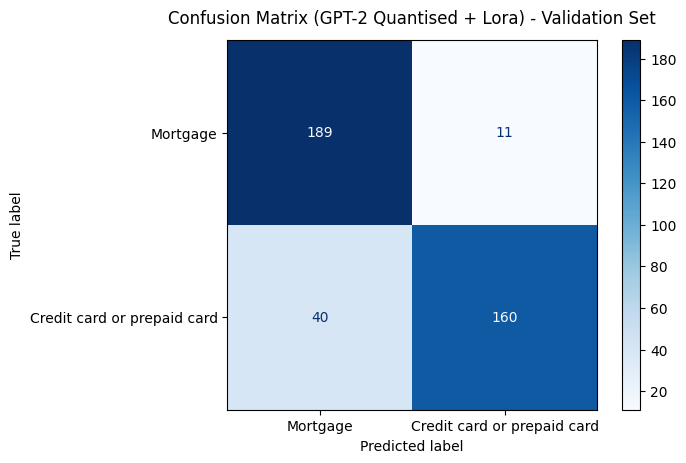

In [18]:
create_confusion_matrix(data = tokenized_dataset["test"],
                        cl_classes= product_classes,
                        trainer_ = trainer,
                        title_text = 'Confusion Matrix (GPT-2 Quantised + Lora) - Validation Set')

In [19]:
print(torch.cuda.memory_summary(device = None, abbreviated = False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 238301 KiB |   1637 MiB | 170451 GiB | 170451 GiB |
|       from large pool | 199936 KiB |   1599 MiB | 170100 GiB | 170100 GiB |
|       from small pool |  38365 KiB |     44 MiB |    351 GiB |    351 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 238301 KiB |   1637 MiB | 170451 GiB | 170451 GiB |
|       from large pool | 199936 KiB |   1599 MiB | 170100 GiB |